In [9]:
import pandas as pd
from google.colab import files

# Upload the file
uploaded = files.upload()

# Load the dataset
file_path = next(iter(uploaded))  # Get the uploaded file path

# Read the CSV file into a DataFrame with error handling
try:
    df = pd.read_csv(file_path)
    # Check for and remove empty rows
    df = df.dropna(subset=['review', 'sentiment'])
except Exception as e:
    print("Error occurred while reading the CSV file:", e)

# Check column names
print(df.columns)

# Inspect the first few rows of the DataFrame
print(df.head(20))

Saving IMDB Dataset.csv to IMDB Dataset (1).csv
Index(['review', 'sentiment'], dtype='object')
                                               review sentiment
0   One of the other reviewers has mentioned that ...  positive
1   A wonderful little production. <br /><br />The...  positive
2   I thought this was a wonderful way to spend ti...  positive
3   Basically there's a family where a little boy ...  negative
4   Petter Mattei's "Love in the Time of Money" is...  positive
5   Probably my all-time favorite movie, a story o...  positive
6   I sure would like to see a resurrection of a u...  positive
7   This show was an amazing, fresh & innovative i...  negative
8   Encouraged by the positive comments about this...  negative
9   If you like original gut wrenching laughter yo...  positive
10  Phil the Alien is one of those quirky films wh...  negative
11  I saw this movie when I was about 12 when it c...  negative
12  So im not a big fan of Boll's work but then ag...  negative
13  The c

In [10]:
import re

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    return text

# Apply preprocessing
df['review'] = df['review'].apply(preprocess_text)

In [11]:
# Use the actual sentiment for further processing
df['Sentiment'] = df['sentiment']

# Filter out neutral sentiments if needed
df = df[df['Sentiment'] != 'Neutral']

# Display the first 10 reviews with actual sentiments
print("\nFirst 10 Reviews with Actual Sentiments:")
first_10_df = df.head(10)
for index, row in first_10_df.iterrows():
    print(f"Review: {row['review']}\nActual Sentiment: {row['Sentiment']}\n")

# Display the last 10 reviews with actual sentiments
print("\nLast 10 Reviews with Actual Sentiments:")
last_10_df = df.tail(10)
for index, row in last_10_df.iterrows():
    print(f"Review: {row['review']}\nActual Sentiment: {row['Sentiment']}\n")


First 10 Reviews with Actual Sentiments:
Review: one of the other reviewers has mentioned that after watching just 1 oz episode you ll be hooked they are right as this is exactly what happened with me br br the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word br br it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away br br i would say the main appeal of the show is due to 

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Prepare data for model training
X = df['review']
y = df['Sentiment']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Define the parameter grid for regularization
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Use GridSearchCV to find the best regularization parameter
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

# Get the best model
model = grid_search.best_estimator_

print(f"Best regularization parameter: {grid_search.best_params_['C']}")

# Perform cross-validation to collect training and validation scores
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_accuracies = []
val_accuracies = []

for train_index, val_index in cv.split(X, y):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    X_train_tfidf_fold = vectorizer.fit_transform(X_train_fold)
    X_val_tfidf_fold = vectorizer.transform(X_val_fold)

    model.fit(X_train_tfidf_fold, y_train_fold)

    train_accuracy = model.score(X_train_tfidf_fold, y_train_fold)
    val_accuracy = model.score(X_val_tfidf_fold, y_val_fold)

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

Best regularization parameter: 1


In [22]:
# Display the first 10 reviews with predicted and actual sentiments
print("\nFirst 10 Reviews with Predicted and Actual Sentiments:")
first_10_pred_df = df.head(10)
first_10_pred_df['Predicted_Sentiment'] = model.predict(vectorizer.transform(first_10_pred_df['review']))
for index, row in first_10_pred_df.iterrows():
    print(f"Review: {row['review']}\nActual Sentiment: {row['Sentiment']}\nPredicted Sentiment: {row['Predicted_Sentiment']}\n")

# Display the last 10 reviews with predicted and actual sentiments
print("\nLast 10 Reviews with Predicted and Actual Sentiments:")
last_10_pred_df = df.tail(10)
last_10_pred_df['Predicted_Sentiment'] = model.predict(vectorizer.transform(last_10_pred_df['review']))
for index, row in last_10_pred_df.iterrows():
    print(f"Review: {row['review']}\nActual Sentiment: {row['Sentiment']}\nPredicted Sentiment: {row['Predicted_Sentiment']}\n")


First 10 Reviews with Predicted and Actual Sentiments:
Review: one of the other reviewers has mentioned that after watching just 1 oz episode you ll be hooked they are right as this is exactly what happened with me br br the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word br br it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away br br i would say the main appeal of the s

<ipython-input-22-e95bf6b93ed0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_10_pred_df['Predicted_Sentiment'] = model.predict(vectorizer.transform(first_10_pred_df['review']))
<ipython-input-22-e95bf6b93ed0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_10_pred_df['Predicted_Sentiment'] = model.predict(vectorizer.transform(last_10_pred_df['review']))


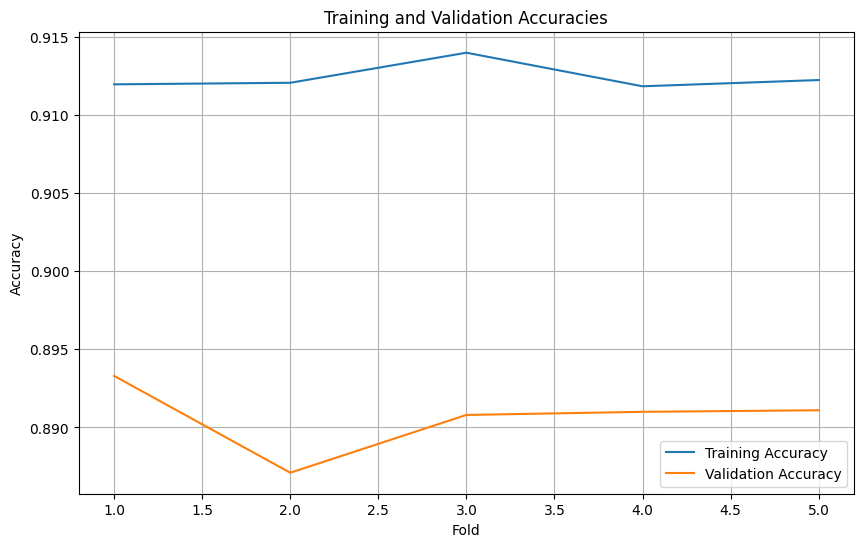

In [23]:
import matplotlib.pyplot as plt

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
from sklearn.metrics import accuracy_score, classification_report

# Final evaluation on the full training and validation sets
model.fit(X_train_tfidf, y_train)

y_train_pred = model.predict(X_train_tfidf)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

y_val_pred = model.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy}")
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Check for overfitting or underfitting
if train_accuracy > val_accuracy:
    print("The model might be overfitting. Consider using stronger regularization or collecting more data.")
elif train_accuracy < val_accuracy:
    print("The model might be underfitting. Consider increasing the model complexity or trying different features.")
else:
    print("The model seems to be fitting well.")

Training Accuracy: 0.911975
Training Classification Report:
              precision    recall  f1-score   support

    negative       0.92      0.91      0.91     20039
    positive       0.91      0.92      0.91     19961

    accuracy                           0.91     40000
   macro avg       0.91      0.91      0.91     40000
weighted avg       0.91      0.91      0.91     40000

Validation Accuracy: 0.8959
Validation Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      4961
    positive       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

The model might be overfitting. Consider using stronger regularization or collecting more data.
